In [1]:
import torch
import pytorch_lightning as pl
import yaml
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from glob import glob

In [2]:
sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE")

In [3]:
from scripts.diffusion.schedules import TimestepSampler
from scripts.diffusion.ResUnet_timeembed import Unet_bg
from run.diffusion.run_diffusion import DDPM

from scripts.maploader.maploader import get_data_from_params, get_normalized_from_params
from scripts.utils.run_utils import setup_trainer, set_params

/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pl.seed_everything(1234)

[rank: 0] Global seed set to 1234


1234

In [5]:
def monitor_mem():
    t = torch.cuda.get_device_properties(0).total_memory
    a = torch.cuda.memory_allocated(0)
    print("allocated memory:{0}MB, used {1:.1f}% of total".format(a//1024**2, (a/t*100)))

# Data Loading

In [6]:
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
target = "difference"
model_type = "diffusion"
scheduler = "linear"
order=4
n_maps=1
batch_size=16
params = set_params(base_dir, target, model_type, scheduler, order, n_maps, batch_size)

In [7]:
version = "0"
ckpt_dir = f"{params['train']['save_dir']}rough/{params['train']['log_name']}/version_{version}"

In [8]:
# Load data
lr, hr = get_data_from_params(params)
data_input, data_condition, transforms_lr, inverse_transforms_lr, transforms_hr, inverse_transforms_hr, range_min_lr, range_max_lr, range_min_hr, range_max_hr = get_normalized_from_params(lr, hr, params)

LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc128/.  Number of maps: 1
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/FastPM/healpix/nc256/.  Number of maps: 1
data nside: 512, divided into 192 patches, each patch has 16384 pixels.
LR data normalized to [-1.0,1.0] by both transform.
Difference data calculated from HR - LR*upsample_scale^3. min: -191.99996948242188, max: 176.0
Difference data normalized to [-1.0,1.0] by both transform.


In [9]:
# set up model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
#get sampler type
timesteps = int(params['diffusion']['timesteps'])
sampler = TimestepSampler(timesteps=timesteps, sampler_type=params['diffusion']['sampler_type'])

In [11]:
#get model
model = DDPM(Unet_bg, params, sampler = sampler).to(device)
monitor_mem()

We are using Adam with lr = 0.0001, gamma = 0.9999
The schedule is linear with beta_start = 1e-06, beta_end = 0.01
allocated memory:301MB, used 2.7% of total


In [12]:
ckpt_path = sorted(glob(f"{ckpt_dir}/checkpoints/*.ckpt"), key=lambda x: float(x.split('=')[-1].rsplit('.', 1)[0]))[-1]
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["state_dict"], strict=False)
model.eval()
print("Model loaded")
monitor_mem()
#get diffusion
tmp_diffusion = model.diffusion

Model loaded
allocated memory:1043MB, used 9.5% of total


In [13]:
PATCH_SIZE = 12 * params["data"]["order"] **2
lr_sample = np.hstack(lr[:PATCH_SIZE, :, 0].detach().cpu().numpy()) 
hr_sample = np.hstack(hr[:PATCH_SIZE, :, 0].detach().cpu().numpy())
noisy_hr_sample = hr_sample + np.random.normal(0, 0.4, hr_sample.shape)
diff_sample = hr_sample - lr_sample
noisy_diff_sample = diff_sample + np.random.normal(0, 0.4, diff_sample.shape)
noise_sample = np.random.normal(0, 0.4, hr_sample.shape)

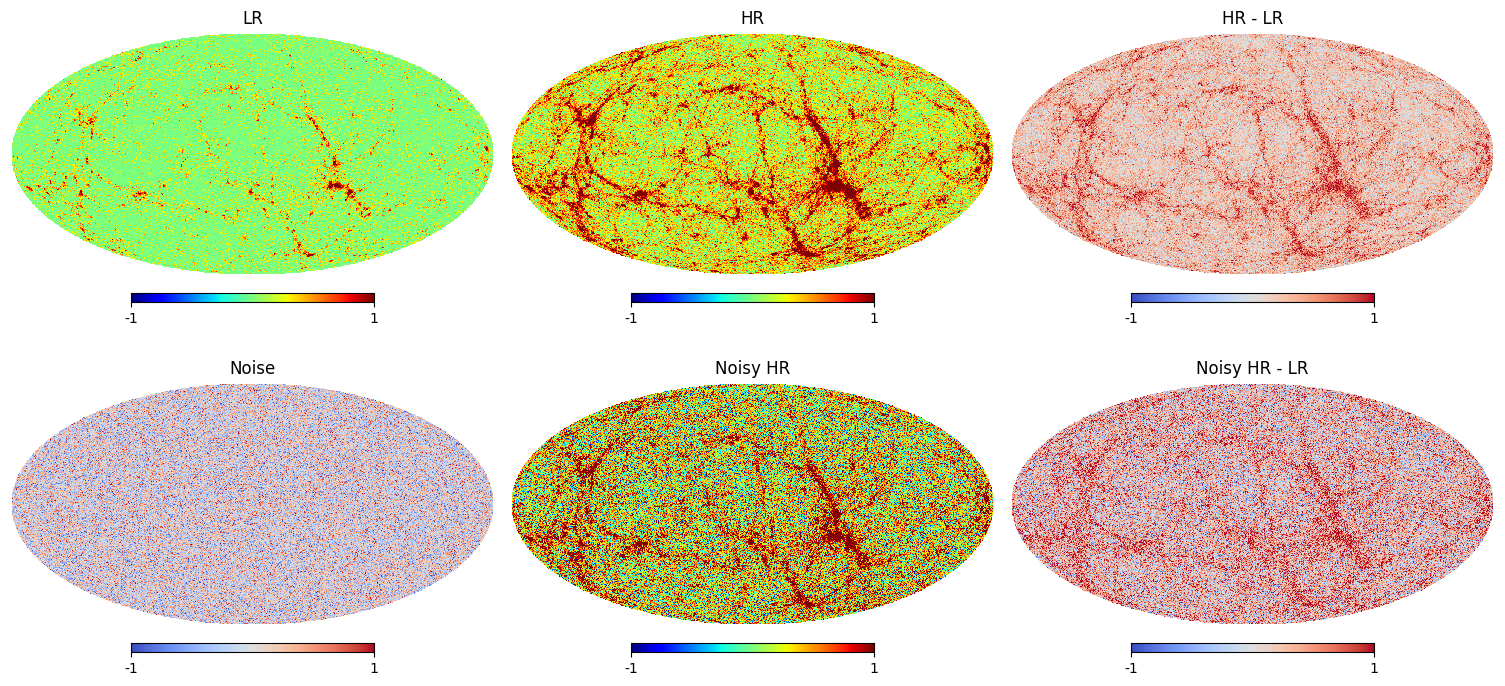

In [14]:
fig = plt.figure(figsize=(15, 7))
hp.mollview(lr_sample, fig=fig, nest=True, title="LR", sub=(2, 3, 1), min=-1, max=1, cmap='jet')
hp.mollview(hr_sample, fig=fig, nest=True, title="HR", sub=(2, 3, 2), min=-1, max=1, cmap='jet')
hp.mollview(diff_sample, fig=fig, nest=True, title="HR - LR", sub=(2, 3, 3), min=-1, max=1, cmap='coolwarm')
hp.mollview(noisy_hr_sample, fig=fig, nest=True, title="Noisy HR", sub=(2, 3, 5), min=-1, max=1, cmap='jet')
hp.mollview(noisy_diff_sample, fig=fig, nest=True, title="Noisy HR - LR", sub=(2, 3, 6), min=-1, max=1, cmap='coolwarm')
hp.mollview(noise_sample, fig=fig, nest=True, title="Noise", sub=(2, 3, 4), min=-1, max=1, cmap='coolwarm')
plt.show()

In [15]:
print("Start Diffusion")
test_batch = 4
tmp_sample = data_input[:test_batch].to(device)
tmp_lr = data_condition[:test_batch].to(device)
imgs = []
img = torch.randn(tmp_sample.shape, device=device)
stats = {"min":{}, "max":{}, "cov":{}}
monitor_mem()
with torch.no_grad():
    for j in reversed(range(int(timesteps*5/8))):
        t = torch.full((test_batch,), j, device=device, dtype=torch.long)
        model.model.eval()
        img = tmp_diffusion.p_sample(model.model, img, t, t_index=j, condition=tmp_lr)
        stats["min"][j] = img.min().detach().cpu().numpy()
        stats["max"][j] = img.max().detach().cpu().numpy()
        stats["cov"][j] = np.cov(img.detach().cpu().numpy().reshape(-1))
        if j%10==0:
            loss = tmp_diffusion.p_losses(model.model, tmp_sample, t, condition=tmp_lr, loss_type=params['diffusion']['loss_type']).detach()
            print('Current step {}, Loss {}'.format(j, loss), flush=True)
            imgs.append(img.detach().cpu().numpy())
        if img.min() < -1e1 or img.max() > 1e1:
            print("Diverged at step {}, aborting.".format(j))
            break

Start Diffusion
allocated memory:1044MB, used 9.5% of total
Current step 1240, Loss 0.06005057319998741
Current step 1230, Loss 0.047529809176921844
Current step 1220, Loss 0.03537057712674141
Current step 1210, Loss 0.03660442680120468
Current step 1200, Loss 0.04533722251653671
Current step 1190, Loss 0.03599676489830017
Current step 1180, Loss 0.05838407576084137
Current step 1170, Loss 0.07446365803480148
Current step 1160, Loss 0.03588046133518219
Current step 1150, Loss 0.039791956543922424
Current step 1140, Loss 0.039400942623615265
Current step 1130, Loss 0.03600720316171646
Current step 1120, Loss 0.04520731046795845
Current step 1110, Loss 0.0617477223277092
Current step 1100, Loss 0.05489320307970047
Current step 1090, Loss 0.03744035214185715
Current step 1080, Loss 0.05790594965219498
Current step 1070, Loss 0.038830194622278214
Current step 1060, Loss 0.04290267080068588
Current step 1050, Loss 0.03842411935329437
Current step 1040, Loss 0.04805704206228256
Current step 

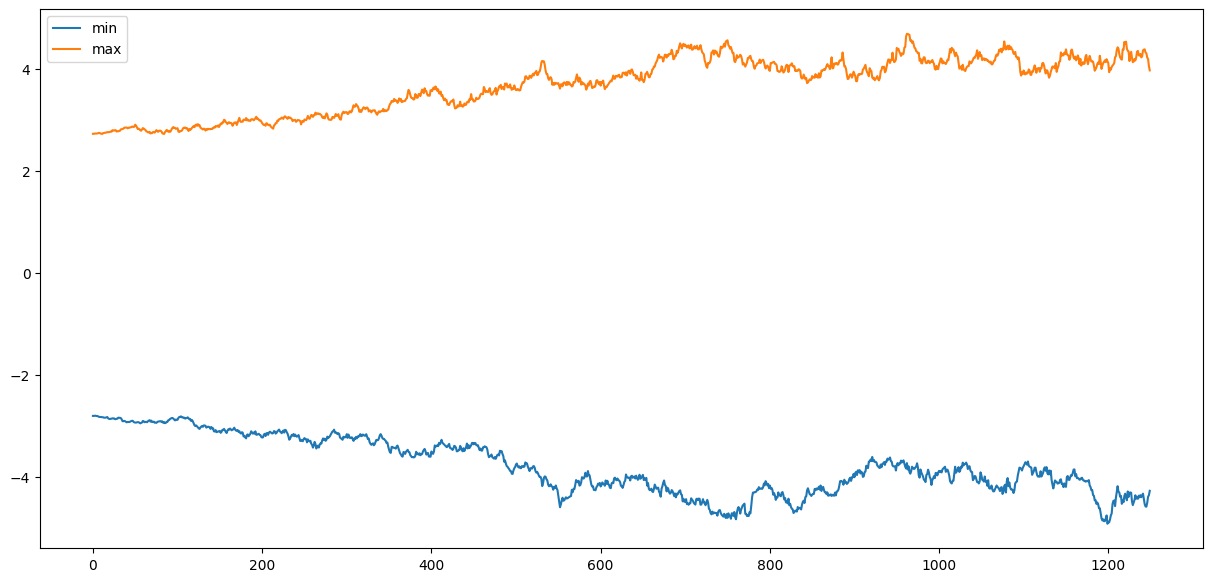

In [16]:
fig = plt.figure(figsize=(15, 7))
plt.plot(stats["min"].keys(), stats["min"].values(), label="min")
plt.plot(stats["max"].keys(), stats["max"].values(), label="max")
plt.legend()
plt.show()

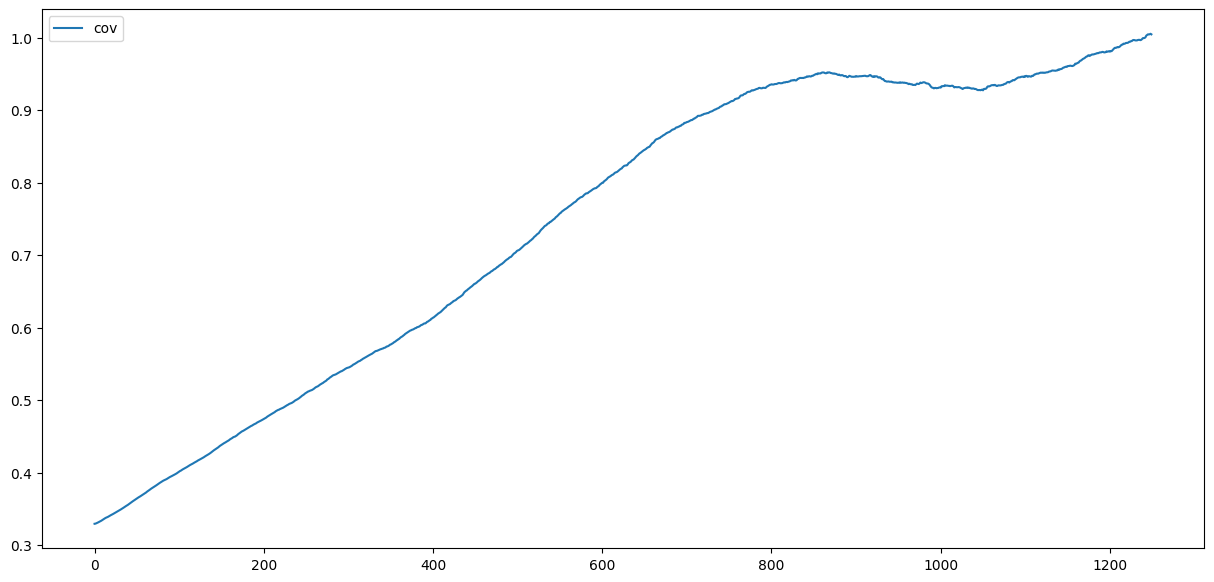

In [17]:
fig = plt.figure(figsize=(15, 7))
plt.plot(stats["cov"].keys(), stats["cov"].values(), label="cov")
plt.legend()
plt.show()

# Visualization

In [23]:
np.hstack(np.vstack([imgs[-1][:,:,0]]*3)).shape

(196608,)

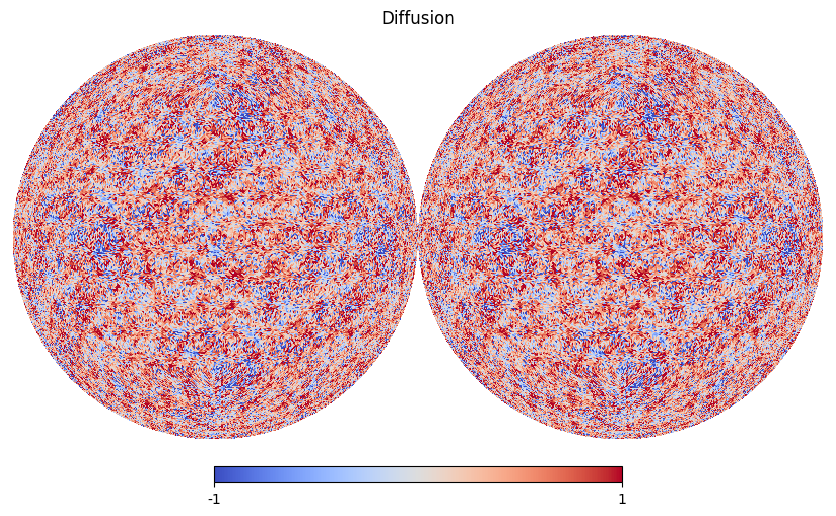

In [31]:
hp.orthview(np.hstack(np.vstack([imgs[-1][3,:,0]]*12)),cmap="coolwarm", nest=True,title="Diffusion", min=-1, max=1)

In [5]:
def read_maps(map_dir, diffsteps=100, batch_size=4):
    maps = sorted(glob(map_dir + "/*.npy"), key=lambda x: (int(x.split("/")[-1].split("_")[2]), int(x.split("/")[-1].split(".")[0].split("_")[-1])))
    map_diffused = []
    for i in range(diffsteps):
        map_steps = []
        for j in range(batch_size):
            #print("Current map: {}".format(maps[i*batch_size+j]))
            map_steps.append(np.load(maps[i*batch_size+j]))
        map_steps = np.array(map_steps)
        map_steps = np.hstack(map_steps)
        map_diffused.append(map_steps)
    map_diffused = np.array(map_diffused)
    return map_diffused

In [11]:
NUM_BATCHES = int(12 * (config_dict['data']['order'])**2 / (config_dict['train']['batch_size']*2))
timesteps = int(config_dict['diffusion']['timesteps'])
map_dir = f"{base_dir}/results/imgs/diffusion/{target}/{config_dict['train']['log_name']}/version_{version}"
map_diffused = read_maps(map_dir, diffsteps=timesteps//10, batch_size=NUM_BATCHES)
print(f"map_diffused.shape: {map_diffused.shape}")

map_diffused.shape: (100, 3145728)


In [12]:
map_dir

'/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/results/imgs/diffusion/difference/difference_linear_o2_b6/version_2'

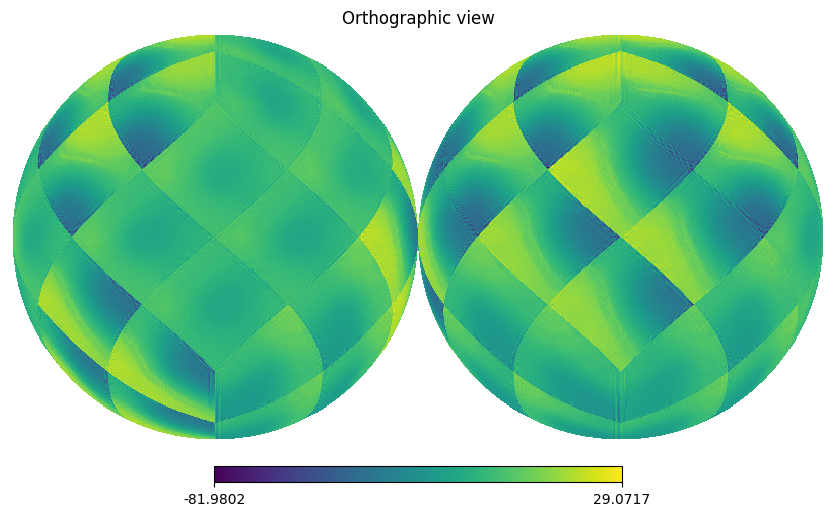

In [16]:
hp.orthview(map_diffused[0], nest=True)

In [19]:
map_diffused = read_maps(map_dir, diffsteps=100, batch_size=16)

In [23]:
lr = get_data(lrmaps_dir, n_maps, nside, order, issplit=False)
hr = get_data(hrmaps_dir, n_maps, nside, order, issplit=False)

hr, transforms_hr, inverse_transforms_hr, range_min_hr, range_max_hr = get_minmaxnormalized_data(hr)
print("HR data loaded. min: {}, max: {}".format(range_min_hr, range_max_hr))

lr = transforms_hr(lr)
print("LR data normalized by HR range. min: {}, max: {}".format(lr.min(), lr.max()))

HR data loaded. min: 0.0, max: 2.903632402420044
LR data normalized by HR range. min: -1.0, max: 0.38642704486846924


In [86]:
lr_hp = inverse_transforms_hr(lr).detach().cpu().numpy()[0, : , 0]
lr_sample = lr.detach().cpu().numpy()[0, : , 0]
hr_hp = inverse_transforms_hr(hr).detach().cpu().numpy()[0, : , 0]

In [61]:
def t2hpr(x):
    x_hp = hp.pixelfunc.reorder(x, n2r=True)
    return x_hp

def inverse_transforms_hp(x, range_min, range_max):
    x = (x + 1) / 2 * (range_max - range_min) + range_min
    return x

In [167]:
def plot_ps(cls, fig, ax):
    if len(cls) == 2:
        labels = ["input", "target"]
    elif len(cls) == 3:
        labels = ["input", "target", "output"]
    elif len(cls) == 4:
        labels = ["input", "target", "output", "diff"]
    else:
        raise ValueError("cls must be 2 or 3 or 4 length")
    ell = np.arange(len(cls[0]))
    for cl, label in zip(cls, labels):
        ax.plot(ell*(ell+1)*cl/(2*np.pi), label=label, alpha=0.7)
    ax.set_xlabel("l", fontsize=12)
    ax.set_ylabel(r"$l(l+1)C_{l}/2\pi\;\; $", fontsize=12)
    ax.set_yscale("log")
    ax.legend(loc="lower right", fontsize=12)
    return fig, ax

In [168]:
def plot_maps_png(i, sr_hp, lr_hp, hr_hp, png_dir, tmp_min, tmp_max, verbose=False):
    fig = plt.figure(figsize=(12,4))
    hp.mollview(sr_hp, nest=True, fig=fig, title=f'Generated Diff step_{str((99-i)*10).zfill(3)}+ LR', sub=(1,3,1), min=tmp_min, max=tmp_max)
    hp.mollview(hr_hp, nest=True, fig=fig, title='HR', sub=(1,3,2), min=tmp_min, max=tmp_max)
    hp.mollview(lr_hp, nest=True, fig=fig, title='LR', sub=(1,3,3), min=tmp_min, max=tmp_max)
    if verbose:
        plt.show()
    else:
        fig.savefig(png_dir + f"/step_{(99-i)*10}.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

def plot_ps_png(i, cls, ps_dir, lmax, verbose=False):
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    fig, ax = plot_ps(cls, fig, ax)
    ax.set_title(f"step_{str((99-i)*10).zfill(3)}")
    if verbose:
        plt.show()
    else:
        fig.savefig(ps_dir + f"/step_{(99-i)*10}_ps.png", dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

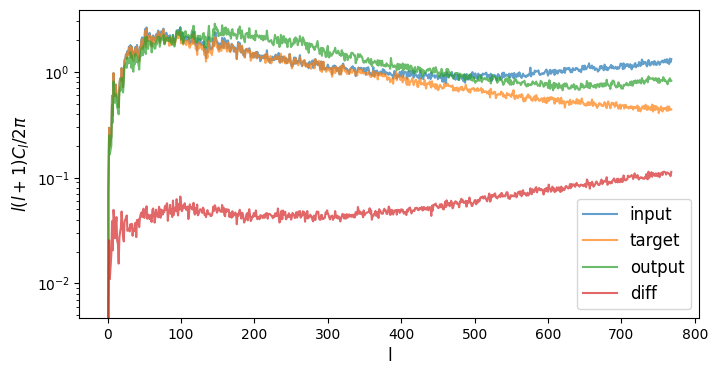

In [169]:
output_cl =hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(sr_hp)-1), lmax=lmax)
diff_cl = hp.sphtfunc.anafast(np.exp(np.log(10)*t2hpr(sr_hp - lr_hp)-1), lmax=lmax)
cls = [input_cl, target_cl, output_cl, diff_cl]

fig, ax = plt.subplots(1,1, figsize=(8,4))
fig, ax = plot_ps(cls, fig, ax)

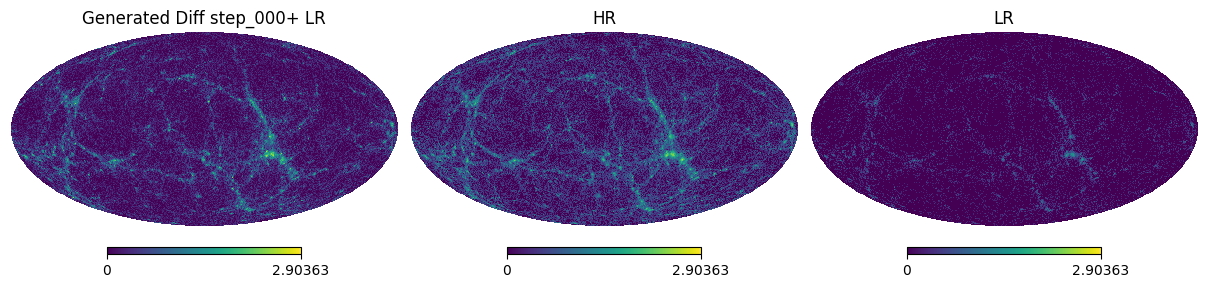

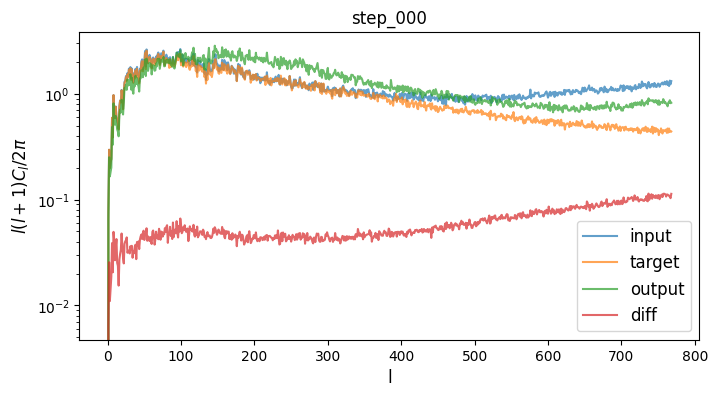

In [170]:
plot_maps_png(99, sr_hp, lr_hp, hr_hp, map_dir + "/png", range_min_hr, range_max_hr, True)
plot_ps_png(99, cls, map_dir + "/ps", 3*nside, True)